In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import blip_analysis as ba
import exp_blip_models as em
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from copy import deepcopy
from sklearn.cluster import OPTICS, KMeans
from scipy import stats
from tqdm import trange
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import dask
from scipy.stats import poisson
from sklearn.metrics import adjusted_rand_score
from daskify import Daskified
from label_axes import label_axes
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

b


In [2]:
diff_models1 = pickle.Unpickler(open('../Fig4/../Fig4/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Fig4/../Fig4/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Fig4/../Fig4/230320_diff_models3.pkl', 'rb')).load()

In [3]:
[i.fit() for i in diff_models1]
[i.fit() for i in diff_models2]
[i.fit() for i in diff_models3]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [4]:
bins1 = np.array([i.opt_out.x[:-1] for i in diff_models1])
bins2 = np.array([i.opt_out.x[:-1] for i in diff_models2])
bins3 = np.array([i.opt_out.x[:-1] for i in diff_models3])

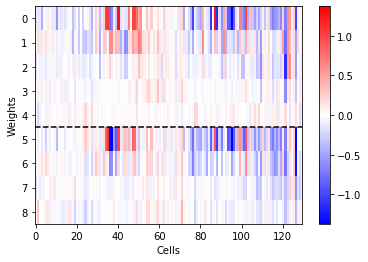

In [17]:
vmax = np.max(np.abs(bins1))
plt.imshow(bins1.T, cmap='bwr', vmin=-vmax, vmax=vmax, aspect='auto')
plt.xlabel('Cells')
plt.ylabel('Weights')
plt.axhline(4.5, color='k', linestyle='--')
plt.colorbar()

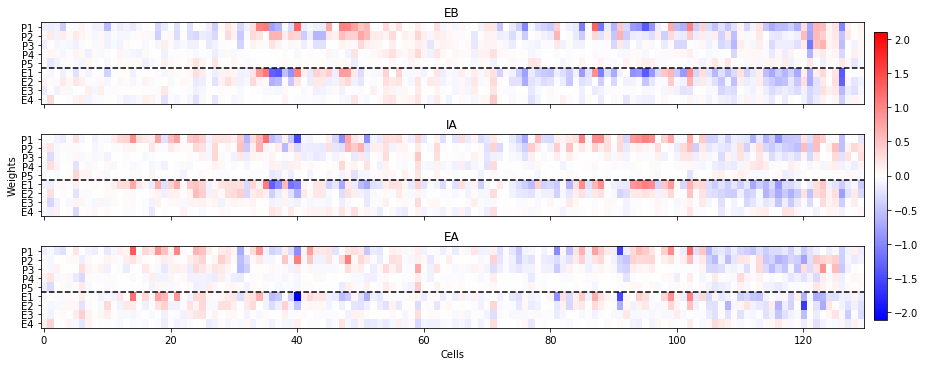

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(12, 5), sharex=True)
vmax = np.max([np.abs(bins1), np.abs(bins2), np.abs(bins3)])
im = ax[0].imshow(bins1.T, cmap='bwr', vmin=-vmax, vmax=vmax, aspect='auto')
ax[1].imshow(bins2.T, cmap='bwr', vmin=-vmax, vmax=vmax, aspect='auto')
ax[2].imshow(bins3.T, cmap='bwr', vmin=-vmax, vmax=vmax, aspect='auto')


titles = ['EB', 'IA', 'EA']
for i in ax:
    i.axhline(4.5, color='k', linestyle='--')
    i.set_yticks(range(0, 10))
    i.set_ylim(8.5, -0.5)
    i.set_yticklabels(['P1', 'P2', 'P3', 'P4', 'P5', 'E1', 'E2', 'E3', 'E4'])
    i.set_title(titles.pop(0))
plt.tight_layout()
ax[-1].set_xlabel('Cells')
ax[1].set_ylabel('Weights')
cbax = fig.add_axes([1, 0.1, 0.015, 0.8])
plt.colorbar(im, cax=cbax)

In [10]:
### Clustering

pca1 = PCA(n_components=9)
pcad_bins1 = pca1.fit_transform(bins1)
pca2 = PCA(n_components=9)
pcad_bins2 = pca2.fit_transform(bins2)
pca3 = PCA(n_components=9)
pcad_bins3 = pca3.fit_transform(bins3)
pca_all = PCA(n_components=9)
pcad_bins_all = pca_all.fit_transform(np.concatenate([bins1, bins2, bins3], axis=0))

opts1 = OPTICS()
opts1.fit(pcad_bins1[:, :2])
opts2 = OPTICS()
opts2.fit(pcad_bins2[:, :2])
opts3 = OPTICS()
opts3.fit(pcad_bins3[:, :2])
opts_all = OPTICS()
opts_all.fit(pcad_bins_all[:, :2])

OPTICS()

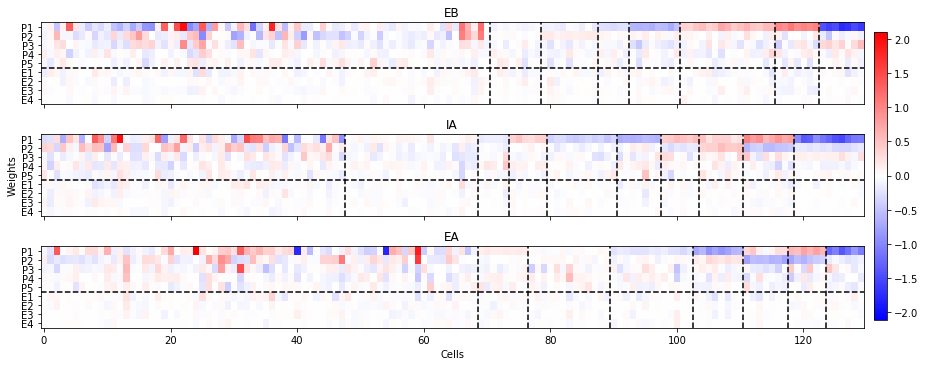

In [12]:
sorted_args1 = np.argsort(opts1.labels_)
sorted_args2 = np.argsort(opts2.labels_)
sorted_args3 = np.argsort(opts3.labels_)
fig, ax = plt.subplots(3, 1, figsize=(12, 5), sharex=True)
vmax = np.max([np.abs(bins1), np.abs(bins2), np.abs(bins3)])
im = ax[0].imshow(pcad_bins1[sorted_args1].T, cmap='bwr', vmin=-vmax, vmax=vmax, aspect='auto')
ax[1].imshow(pcad_bins2[sorted_args2].T, cmap='bwr', vmin=-vmax, vmax=vmax, aspect='auto')
ax[2].imshow(pcad_bins3[sorted_args3].T, cmap='bwr', vmin=-vmax, vmax=vmax, aspect='auto')
counts1 = np.cumsum([np.sum(opts1.labels_ == i) for i in np.unique(opts1.labels_)])[:-1]
counts2 = np.cumsum([np.sum(opts2.labels_ == i) for i in np.unique(opts2.labels_)])[:-1]
counts3 = np.cumsum([np.sum(opts3.labels_ == i) for i in np.unique(opts3.labels_)])[:-1]
for i in counts1:
    ax[0].axvline(i-0.5, color='k', linestyle='--')
for i in counts2:
    ax[1].axvline(i-0.5, color='k', linestyle='--')
for i in counts3:
    ax[2].axvline(i-0.5, color='k', linestyle='--')

titles = ['EB', 'IA', 'EA']
for i in ax:
    i.axhline(4.5, color='k', linestyle='--')
    i.set_yticks(range(0, 10))
    i.set_ylim(8.5, -0.5)
    i.set_yticklabels(['P1', 'P2', 'P3', 'P4', 'P5', 'E1', 'E2', 'E3', 'E4'])
    i.set_title(titles.pop(0))
plt.tight_layout()
ax[-1].set_xlabel('Cells')
ax[1].set_ylabel('Weights')
cbax = fig.add_axes([1, 0.1, 0.015, 0.8])
plt.colorbar(im, cax=cbax)

Text(0, 0.5, 'PC2')

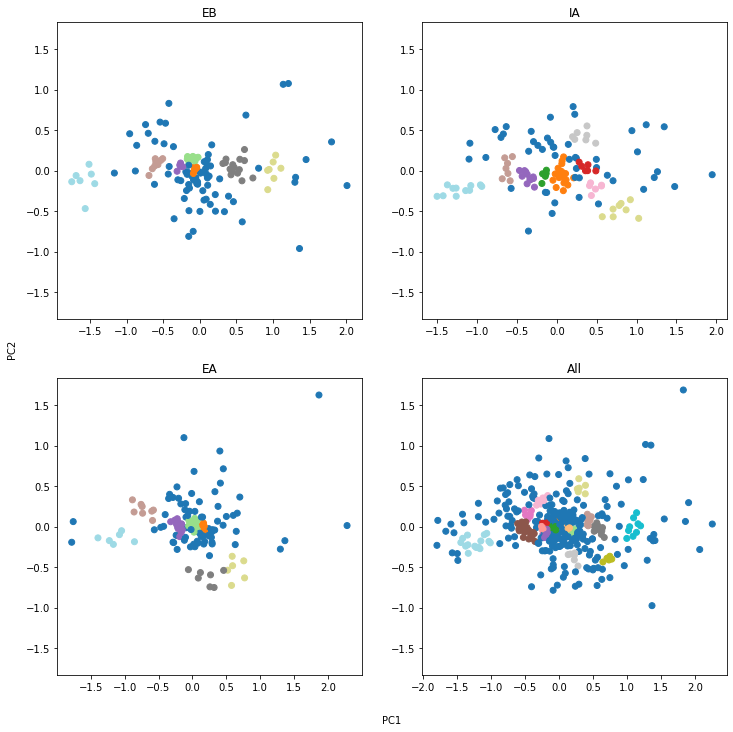

In [77]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()
ax[0].scatter(pcad_bins1[:, 0], pcad_bins1[:, 1], c=opts1.labels_, marker='o', cmap='tab20')
ax[1].scatter(pcad_bins2[:, 0], pcad_bins2[:, 1], c=opts2.labels_, marker='o', cmap='tab20')
ax[2].scatter(pcad_bins3[:, 0], pcad_bins3[:, 1], c=opts3.labels_, marker='o', cmap='tab20')
ax[3].scatter(pcad_bins_all[:, 0], pcad_bins_all[:, 1], c=opts_all.labels_, marker='o', cmap='tab20')

max_ylim = np.max(np.abs([ax[0].get_ylim(), ax[1].get_ylim(), ax[2].get_ylim(), ax[3].get_ylim()]))
[i.set_ylim(-max_ylim, max_ylim) for i in ax];
titles = ['EB', 'IA', 'EA', 'All']
for i in ax:
    i.set_title(titles.pop(0))
title_ax = fig.add_subplot(111, frameon=False)
title_ax.set_xticks([])
title_ax.set_yticks([])
title_ax.set_xlabel('PC1', labelpad=40)
title_ax.set_ylabel('PC2', labelpad=40)

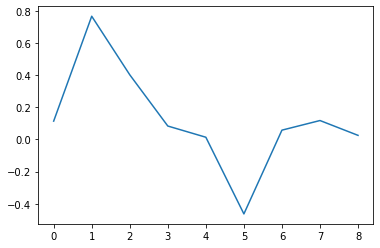

In [74]:
plt.plot(pca_all.components_[1])

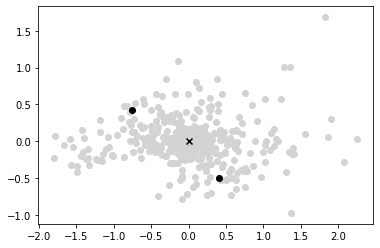

In [95]:
### Across odour angles
minfrac_ui = 5
ui = responsive_units[minfrac_args[minfrac_ui]]
plt.scatter(pcad_bins_all[:, 0], pcad_bins_all[:, 1], color='lightgray')
plt.scatter(pcad_bins_all[ui, 0], pcad_bins_all[ui, 1], color='k')
plt.scatter(pcad_bins_all[ui+130, 0], pcad_bins_all[ui+130, 1], color='k')
plt.scatter([0], [0], marker='x', color='k')

In [64]:
v1 = pcad_bins_all[ui, :2]
v2 = pcad_bins_all[ui+130, :2]
dot_product = np.dot(v1, v2)
norm_v1 = np.linalg.norm(v1)
norm_v2 = np.linalg.norm(v2)
angle = np.arccos(dot_product / (norm_v1 * norm_v2))
print(angle, norm_ang(angle))

2.7544852019052755 0.38710745168451766


In [40]:
norm_ang = lambda x: np.pi-x if x > np.pi/2 else x
def find_angles(ui):
    v1 = pcad_bins_all[ui, :2]
    v2 = pcad_bins_all[ui+130, :2]
    v3 = pcad_bins_all[ui+260, :2]
    dot_product12 = np.dot(v1, v2)
    dot_product13 = np.dot(v1, v3)
    dot_product23 = np.dot(v2, v3)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    norm_v3 = np.linalg.norm(v3)
    cos_theta12 = dot_product12 / (norm_v1 * norm_v2)
    cos_theta13 = dot_product13 / (norm_v1 * norm_v3)
    cos_theta23 = dot_product23 / (norm_v2 * norm_v3)
    theta12 = np.arccos(cos_theta12)
    theta13 = np.arccos(cos_theta13)
    theta23 = np.arccos(cos_theta23)
    return norm_ang(theta12), norm_ang(theta13), norm_ang(theta23)
angles = np.array([find_angles(i) for i in range(130)])

In [45]:
minfrac_args = np.load('../Fig5/230516_minfracs_args_all_responsive.npy')
responsive_units = np.load('../Fig5/230515_all_responsive_cells.npy')

In [46]:
responsive_angles = angles[responsive_units]

24


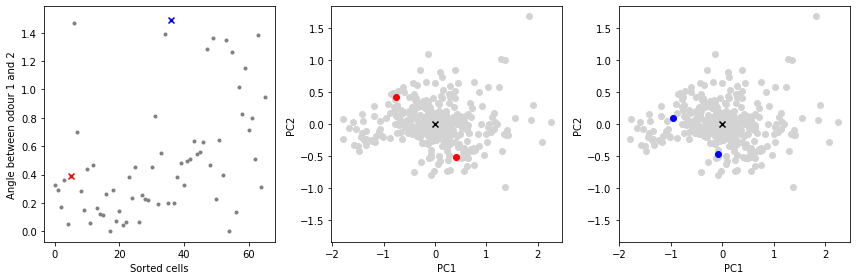

In [122]:
### Across odour angles
minfrac_ui = 5
ui = responsive_units[minfrac_args[minfrac_ui]]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[1].scatter(pcad_bins_all[:, 0], pcad_bins_all[:, 1], color='lightgray')
ax[1].scatter(pcad_bins_all[ui, 0], pcad_bins_all[ui, 1], color='r',)
ax[1].scatter(pcad_bins_all[ui+130, 0], pcad_bins_all[ui+130, 1], color='r')
ax[1].scatter([0], [0], marker='x', color='k')

ax[0].plot(responsive_angles[minfrac_args, 0], '.', color='gray')
#ax[1].xlabel('Sorted cells')
#ax[1].ylabel('Angle between odour 1 and 2')
ax[0].scatter(minfrac_ui, responsive_angles[minfrac_args[minfrac_ui], 0], color='r', marker='x', zorder=10)
ax[0].scatter(36, responsive_angles[minfrac_args[36], 0], color='b', marker='x', zorder=10)

ui = responsive_units[minfrac_args[36]]
ax[2].scatter(pcad_bins_all[:, 0], pcad_bins_all[:, 1], color='lightgray')
ax[2].scatter(pcad_bins_all[ui, 0], pcad_bins_all[ui, 1], color='b',)
ax[2].scatter(pcad_bins_all[ui+130, 0], pcad_bins_all[ui+130, 1], color='b')
ax[2].scatter([0], [0], marker='x', color='k')

max_lims = np.max(np.abs([ax[1].get_ylim(), ax[2].get_ylim()]))
ax[1].set_ylim(-max_lims, max_lims)
ax[2].set_ylim(-max_lims, max_lims)
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
ax[0].set_xlabel('Sorted cells')
ax[0].set_ylabel('Angle between odour 1 and 2')
ax[2].set_xlabel('PC1')
ax[2].set_ylabel('PC2')
plt.tight_layout()
print(ui)

In [51]:
print(np.corrcoef(responsive_angles[:, 0], minfrac_args))

[[1.         0.21145456]
 [0.21145456 1.        ]]
